# 线程池爬中国票房

网址：http://www.boxofficecn.com/boxofficecn

多个线程同时爬取，将不同年份的电影信息保存到不同的文件中。

一般场景下多线程多进程使用的不多，主要是在图片视频资源下载的时候使用。

```python
import time

import requests
from lxml import etree
from concurrent.futures import ThreadPoolExecutor


def str_tools(str_list):
    if str_list:
        text = "".join(str_list).strip()
        return text
    else:
        return ""


def get_movie_info(year):
    f = open(f'{year}.csv', mode='w', encoding='utf-8')  # open打开的文件是线程安全的，多个线程可以同时使用，print打印到控制台不是线程安全的。
    url = f'http://www.boxofficecn.com/boxoffice{year}'
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)"
                      " Chrome/100.0.4896.75 Safari/537.36"
    }

    resp = requests.get(url, headers=headers)

    tree = etree.HTML(resp.text)

    trs = tree.xpath("//table/tbody/tr")[1:]
    print(year, trs)

    for tr in trs:
        num = tr.xpath('./td[1]//text()')  # 返回的是一个字符串列表
        year = tr.xpath('./td[2]//text()')
        name = tr.xpath('./td[3]//text()')
        money = tr.xpath('./td[4]//text()')

        num = str_tools(num)
        year = str_tools(year)
        name = str_tools(name)
        money = str_tools(money)

        f.write(f'{num},{year},{name},{money}\n')
    f.close()


if __name__ == '__main__':
    s1 = time.time()
    with ThreadPoolExecutor(16) as t:
        for i in range(1994, 2023):
            t.submit(get_movie_info, i)
            time.sleep(1)  # 访问网站的频率太快可能会被反爬检测，返回空数据。 网址会限制访问频率
    s2 = time.time()

    print("total time :", s2-s1)  # 多线程下载图片视频资源，所耗时间会显著提升

    """
    下来看下，课件中保存到一个文件中的代码
    """

```

# 斗图网爬取

网址：https://www.pkdoutu.com/photo/list/

这个网站使用的是懒加载图片，先预设一张默认的图片，在访问网页时，放的是默认图片，在下拉的过程中把需要看到的图进行加载，替换默认图片。

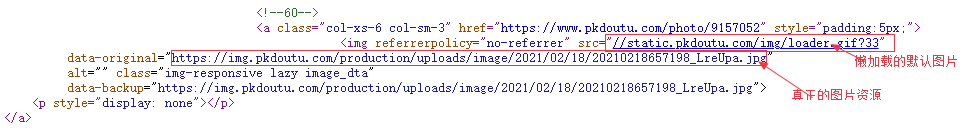

此时页面源代码的img的src属性就不是真正的数据，真正的图片资源在data-original属性中。

## 爬取思路

1. 拿到网页源代码
2. 提取data_original
3. 下载图片


在写的时候，先考虑一页的数据怎么抓取。

## 一页上的数据下载

In [ ]:
import requests
from lxml import etree

headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/100.0.4896.75 Safari/537.36"
    }


def get_img_url():
    url = 'https://www.pkdoutu.com/photo/list/?page=1'
    resp = requests.get(url, headers=headers)

    tree = etree.HTML(resp.text)
    img_url = tree.xpath('//li[@class="list-group-item"]//img/@data-original')  # //img是什么意思？
    for img in img_url:
        print("下载一张图片")
        download_url(img)


def download_url(url):
    file_name = url.split('/')[-1]
    resp = requests.get(url, headers=headers)
    with open(f'./img/{file_name}', mode='wb') as f:
        f.write(resp.content)


if __name__ == '__main__':
    get_img_url()

## 单线程爬取

1. 获取一页的所有图片链接
2. 将这一页获取的到图片链接保存到本地
3. 再去获取下一页，重复步骤1，2

这样的速度很慢，其原因如下：
    
    - 当下载的时候获取页面链接的功能是等待的；
    - 当获取页面链接时，下载功能是等待的；
    - 只有一条线执行
    

## 多线程爬取

多线程是提升当前进程的效率，当前只有一个进程，当线程用于下载时，只是提升了下载的速度，获取图片url此时还是在等待下载完成后，才能进行。

In [ ]:
import time
import requests
from lxml import etree
from concurrent.futures import ThreadPoolExecutor

headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/100.0.4896.75 Safari/537.36"
    }


def get_img_url():
    for page in range(1, 3):
        url = 'https://www.pkdoutu.com/photo/list/?page=1'
        resp = requests.get(url, headers=headers)

        tree = etree.HTML(resp.text)
        img_url = tree.xpath('//li[@class="list-group-item"]//img/@data-original')  # //img是什么意思？
        for img in img_url:
            print("下载一张图片")
            with ThreadPoolExecutor(10) as t:
                t.submit(download_url, img)


def download_url(url):
    file_name = url.split('/')[-1]
    resp = requests.get(url, headers=headers)
    with open(f'./img/{file_name}', mode='wb') as f:
        f.write(resp.content)


if __name__ == '__main__':
    s1 = time.time()
    get_img_url()
    s2 = time.time()
    print('total time: ', s2-s1)

耗时：
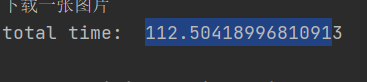

## 多进程爬取

将获取图片url和下载资源分为两个进程，同时进行。使用队列作为两个进程之间的通信工具。

In [ ]:
import time
import requests
from lxml import etree
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Process, Queue

headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/100.0.4896.75 Safari/537.36"
    }


def get_img_url(q):
    for page in range(1, 4):
        url = f'https://www.pkdoutu.com/photo/list/?page={page}'
        resp = requests.get(url, headers=headers)

        tree = etree.HTML(resp.text)
        img_url = tree.xpath('//li[@class="list-group-item"]//img/@data-original')  # //img是什么意思？
        for img in img_url:
            print("下载一张图片", img)
            q.put(img)
    q.put("url end")


def img_process(q):
    with ThreadPoolExecutor(20) as t:
        while True:
            url = q.get()  # 从队列中拿出一个url，如果队列中没有值，会阻塞等待
            if url == 'url end':
                # 所有url都获取完了，后面没有url了
                print('获取图片链接完毕')
                break
            t.submit(download_url, url)


def download_url(url):
    file_name = url.split('/')[-1]
    resp = requests.get(url, headers=headers)
    with open(f'./img/{file_name}', mode='wb') as f:
        f.write(resp.content)


if __name__ == '__main__':
    s1 = time.time()
    # 初始化队列
    q = Queue()
    p_get = Process(target=get_img_url, args=(q,))
    p_download = Process(target=img_process, args=(q,))

    p_get.start()
    p_download.start()

    # 等待子进程结束
    p_get.join()
    p_download.join()

    s2 = time.time()
    print('total time: ', s2-s1)

耗时：
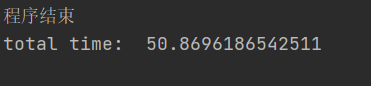

# 协程结合爬虫

通用协程爬虫模板

In [ ]:
import asyncio


async def get_page_source(url):
    print("向服务器请求")
    await asyncio.sleep(3)
    print("拿到服务器数据")

    return "返回请求的数据"

async def main():
    # 一堆将要爬取资源的url
    urls = [
        'www.baidu.com',
        'www,google.com'
    ]
    
    
    ############################# 获取协程函数的返回值 ##########
    #### 方案一：  ####

    # 拿到协程对象并创建对应的任务，在asyncio.create_task的时候就已经开始启动了，但是其任务可能没有执行完
    tasks = [asyncio.create_task(get_page_source(url)) for url in urls]

    # 等待任务完成，result来接收所有协程函数的返回值。
    result, pending = await asyncio.wait(tasks) # 此时所有的任务才执行完了
    # 所有任务执行完后，将任务返回的结果返回到result（第一个返回的结果）中，pending（第二个返回值）可以不关心
    
        
    #### 方案二： ####
    # result = await asyncio.gather(*tasks)
    
    
    for r in result:
        print(r.result())  # 拿到任务返回的结果
    

    ############################# 获取协程函数的返回值 ##########
    print("请求结束")


if __name__ == '__main__':
    m = main()
    asyncio.run(m)

一般很少接收返回值，因为爬取页面html时，协程请求速度快，很容易将网站干崩溃。经常用到协程的场景是下载图片，视频等直接将拿到的数据写入到文件中了，不太用到返回值。

## 支持异步能发送网络请求的模块

requests不支持异步，但是可以在协程函数中使用，但是它慢。需要支持异步的包：

```python
import asyncio

import aiohttp  # pip install aiohttp  替换的requests，异步的请求
import aiofiles  # pip install aiofiles 替换的是open，异步的文件读写
```

### asyncio使用

In [ ]:
import aiohttp
import asyncio
import aiofiles

headers = {}

async def download(url):
    print("向服务器请求")
    file_name = url.split('/')[-1]
    # 如果with后面是一个异步的包，那么绝大多数这里前面要加async
    async with aiohttp.ClientSession() as session:
        async with session.get(url, headers=headers) as resp:  # get的参数和requests.get的参数大多数相同
            # 拿网页源代码：page_source = await resp.text(encoding="utf-8")
            # 拿json: json_data = await resp.json()
            content = await resp.content.read()  # 拿到资源字节数据，在此处挂起，等待网页的响应

            async with aiofiles.open(file_name, mode='wb') as f:  # 异步文件读写操作
                await f.write(content)  # await后面跟的是一个函数的调用，在此处挂起，等待写完数据
    print("获取数据结束")


async def main():
    # 一堆将要爬取源代码的url
    urls = [
        'https://img.h4ck.org.cn/wp-content/uploads/2022/01/20b562a268b9aee4b3403ba601fba85a.jpg',
        'https://img.h4ck.org.cn/wp-content/uploads/2021/09/7c3bc542238f57722ac818f3803174d9-768x513.jpg'
    ]

    # 拿到协程对象并创建对应的任务，在asyncio.create_task的时候就已经开始启动了，但是其任务可能没有执行完
    tasks = [asyncio.create_task(download(url)) for url in urls]

    # 等待任务完成
    await asyncio.wait(tasks)

    print("请求结束")


if __name__ == '__main__':
    # m = main()
    # asyncio.run(m)
    event_loop = asyncio.get_event_loop()
    event_loop.run_until_complete(main())

# 协程爬取明朝那些事

地址：https://www.mingchaonaxieshier.com/

要求：不要让网页死掉了。

其他练手的地址：https://www.51shucheng.net/

分析：
1. 拿到主页面的源代码（不需要异步）
2. 拿到源代码之后，需要解析出 卷名，章节和其href
3. 协程获取小说内容

页面源代码和elements可能会不一样，可以参考elements的信息，最后分析页面还是要以页面源代码为准。

In [ ]:
import os
import requests
from lxml import etree
import asyncio
import aiofiles
import aiohttp

headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36"
    }


def get_chapter_info(url):
    resp = requests.get(url, headers=headers)
    resp.encoding = "UTF-8"
    page_source = resp.text
    # print(page_source)
    tree = etree.HTML(page_source)

    results = []

    divs = tree.xpath("//div[@class='mulu']")
    print(divs)
    for div in divs:  # 拿到七个卷
        trs = div.xpath('.//tr')
        juan_name = trs[0].xpath('.//td//a/text()')  # tr中第一个元素是卷名, 返回的是一个列表
        juan_name = "".join(juan_name).strip().replace("：", "_")
        print(juan_name)
        for tr in trs[1:]:  # 拿到所有的章节，一个tr中有三个章节
            for td in tr.xpath('.//td'):  # 拿到每一个章节
                chapter_name = td.xpath('.//a/text()')
                chapter_href = td.xpath('.//a/@href')
                if chapter_href and chapter_href:  # 最后两个是td是空的，需要排除空的td
                    # 列表转为字符串
                    chapter_name = "".join(chapter_name).strip().replace(" ", "_")
                    chapter_href = "".join(chapter_href).strip()

                    dic = {"juan_name": juan_name, "chapter_name": chapter_name, "chapter_href": chapter_href}
                    results.append(dic)
    return results


async def download_one(url, file_path):
    print("开始下载一章")
    async with aiohttp.ClientSession() as session:
        async with session.get(url, headers=headers) as resp:
            page_source = await resp.text(encoding='UTF-8')
            # 解析小说章节的内容
            tree = etree.HTML(page_source)
            content = tree.xpath('//div[@class="content"]/p/text()')
            # print(content)
            # 列表处理为字符串
            content = "".join(content).strip().replace("\n", "").replace("\t", "").replace(" ", "")

            # 写入文件
            async with aiofiles.open(file_path, mode='w', encoding="UTF-8") as f:
                await f.write(content)

            print("一章下载完成：", file_path, url)


async def download_chapter(chapter_list):
    tasks = []
    for chapter in chapter_list:
        dir_name = chapter.get("juan_name")
        chapter_name = chapter.get("chapter_name")
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        file_path = os.path.join(dir_name, f'{chapter_name}.txt')
        url = chapter.get("chapter_href")

        tasks.append(asyncio.create_task(download_one(url, file_path)))
        # break  # 调试用，不至于干崩网页，调试完成后可以注释
    await asyncio.wait(tasks)


def main():
    url = 'https://www.mingchaonaxieshier.com/'
    chapter_list = get_chapter_info(url)
    # asyncio.run(download_chapter(chapter_list))
    loop_event = asyncio.get_event_loop()
    loop_event.run_until_complete(download_chapter(chapter_list))


if __name__ == '__main__':
    main()

# 协程爬取网吧电影

 网吧电影地址：https://www.wbdy.tv/ 

## 分析

播放视频的标签`video src="视频地址"`

视频播放原理：
    网站视频切片，每次加载几个片段
    有些视频不需要切片。

m3u文件记录着文件视频切片后的正确顺序，通常是utf-8编码。

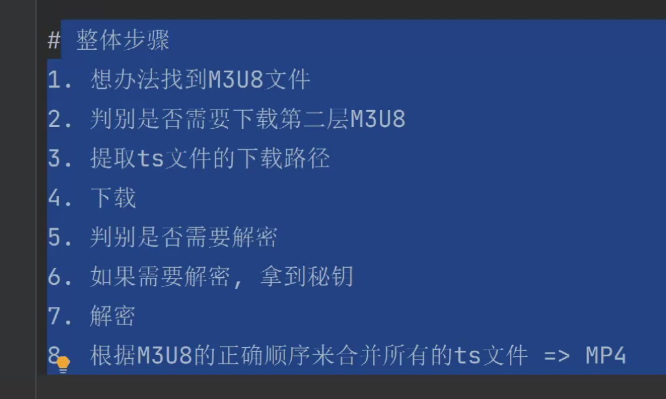

## 分析网页源码

打开视频正在播放的网址：https://www.wbdy.tv/play/63690_1_1.html

视频播放一般是`video`标签，直奔该标签的src属性，简单的网站src的值都是视频文件，可以直接通过src直接获取视频。

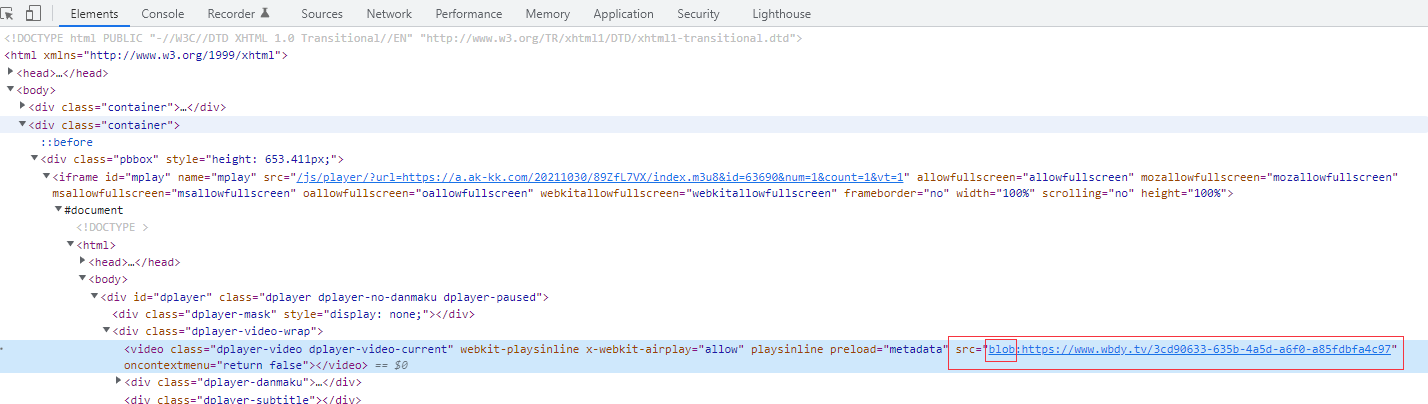

如果一个网站`video`标签的src的值不是视频，那就是视频进行切分了。一般的切分的规则是
- 将视频转为不同的分辨率
- 不同分辨率的进行切分才很小的片段，不会一次全部加载视频资源，会一段一段的加载视频资源。
- 切分为小片段之后，其顺序是存储在**m3u8**文件中
- 在页面源代码中检索m3u8关键字，如果没有，就只能去抓包一个一个看哪个和m3u8内容的格式类似，那就是你要找的目标文件。

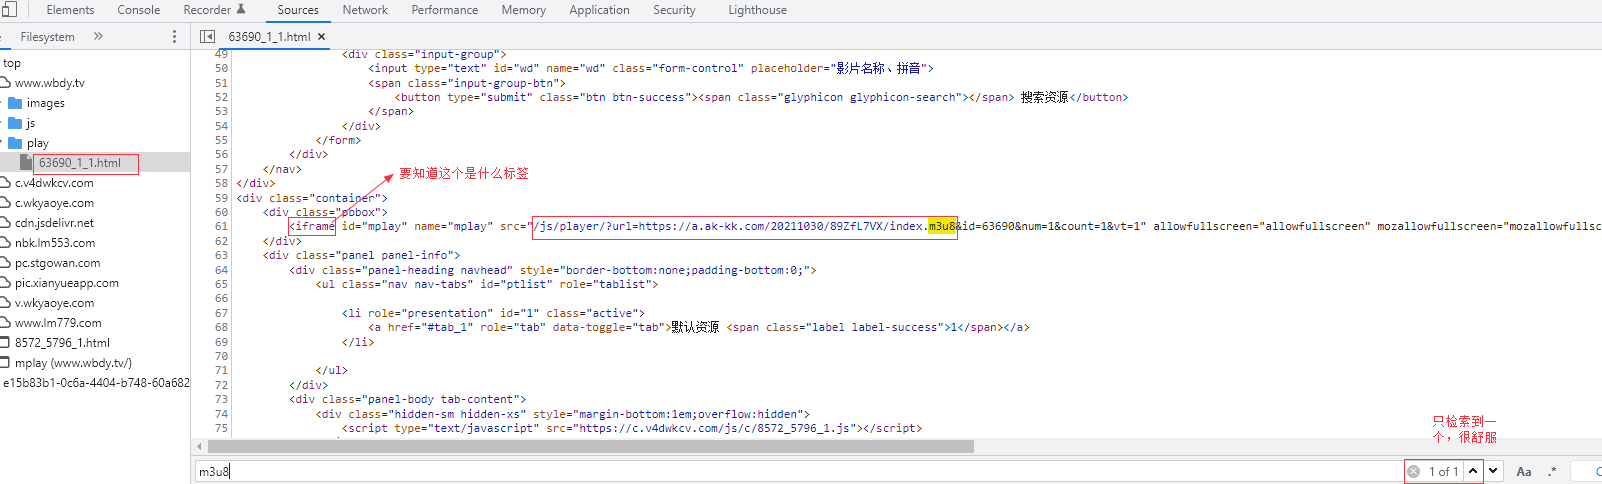

iframe就是在自己的网页上开一个窗口，把其他网站的页面信息展示到这个窗口上。

查看m3u8文件内容

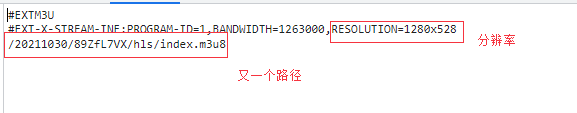

这个文件没有找到切分成片段的视频信息，只给出了一个地址，所以这个地址可能放的就是真正我们需要的文件。

但是这个不是一个完全的请求路径，前面拼接的是什么内容？
- 答：从哪个url来的就和哪个拼接，这个文件的URL是`https://a.ak-kk.com/20211030/89ZfL7VX/index.m3u8`。所以和这个url拼接

拼接url

In [4]:
from urllib.parse import urljoin

url1 = 'https://a.ak-kk.com/20211030/89ZfL7VX/index.m3u8'
url2 = '/20211030/89ZfL7VX/hls/index.m3u8'

urljoin(url1, url2)

'https://a.ak-kk.com/20211030/89ZfL7VX/hls/index.m3u8'

查看拼接好的请求获取的数据

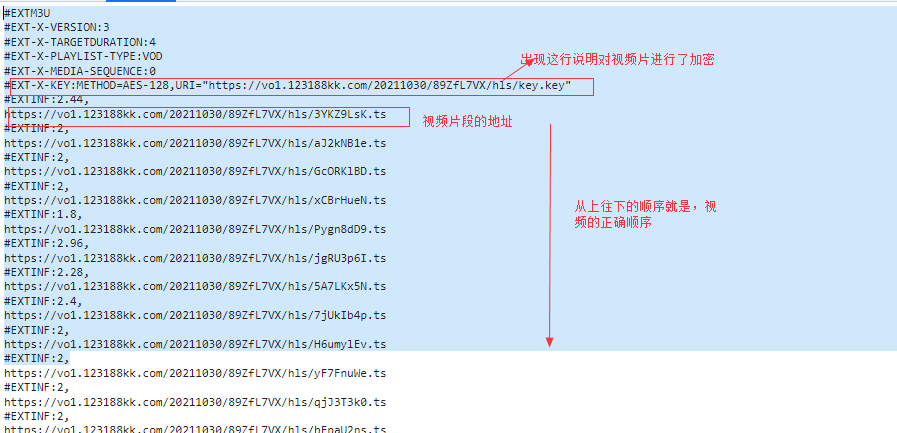

加密的分析
`EXT-X-KEY:METHOD=AES-128,URI="https://vo1.123188kk.com/20211030/89ZfL7VX/hls/key.key"`

- METHOD=AES-128, 指定的是加密算法 AES
- URI="https://vo1.123188kk.com/20211030/89ZfL7VX/hls/key.key", 指向的是解密的秘钥


解密

从`METHOD`可以知道其加密算法是AES-128，可以自行查阅此算法的解密方式。

```python
from Crypto.Cipher import AES  # 安装：pip install pycryptodome , 注意在windows上导包有可能是crypto或者Crypto,自己试
# 解密
# 固定逻辑, 创建一个加密器
aes = AES.new(key=key, mode=AES.MODE_CBC, IV=b"0000000000000000")  # 一般常用的解密模式是MODE_CBC和另一个？需要自己试出来解密模式是哪个。
new_content = aes.decrypt(content)
```

协程经典错误
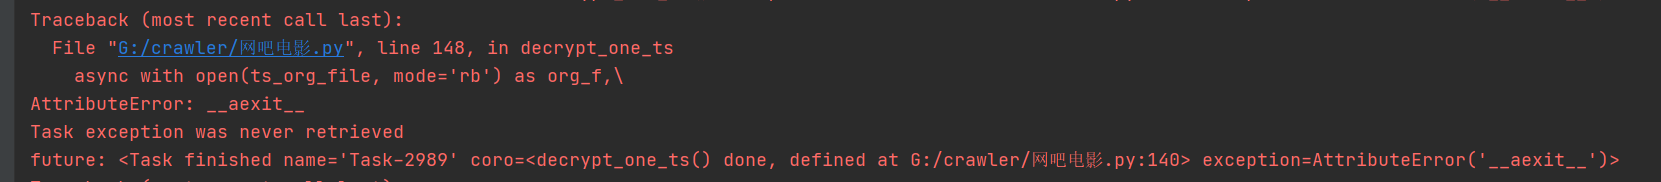

## 完整代码

```python
import re
import os
import requests
from lxml import etree
from urllib.parse import urljoin

import asyncio
import aiofiles
import aiohttp

from Crypto.Cipher import AES


headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36"
    }

current_dir = os.path.abspath(os.path.dirname(os.path.realpath(__file__)))

# data_dir = os.path.join(current_dir, "春夏秋冬有一春")
data_dir = os.path.join(current_dir, "长津湖")

ts_dir = os.path.join(data_dir, "解密前")

decrypt_ts_dir = os.path.join(data_dir, "解密后")


def get_last_m3u8_data(m3u8_url):
    # 如果有多层的m3u8，拿到最后一层的数据，是真正的m3u8内容
    # print(m3u8_url)
    second_m3u8_path = None
    m3u8_resp = requests.get(m3u8_url, headers=headers)
    m3u8_data = m3u8_resp.text

    for line in m3u8_data.split("\n"):
        if line.startswith('#'):
            continue
        # 如果该文件中有.m3u8结尾的就认为还有一层
        if line.endswith('m3u8'):
            second_m3u8_path = line.strip()
            break

    if second_m3u8_path:
        # 获取第二层的m3u8文件, 拼接url，从谁来就和谁拼接
        second_path = urljoin(m3u8_url, second_m3u8_path)
        return get_last_m3u8_data(second_path)
    else:
        return m3u8_data


def get_m3u8(url):
    resp = requests.get(url, headers=headers)
    resp.encoding = "utf-8"
    page_source = resp.text
    m3u8_file = os.path.join(data_dir, 'index.m3u8')

    # 获取m3u8文件地址
    tree = etree.HTML(page_source)
    m3u8_path = tree.xpath("//iframe/@src")
    if m3u8_path:
        m3u8_path = m3u8_path[0]
        # 获取正确的地址
        r = re.compile('url=(?P<url_path>.*?)&')
        m3u8_url = r.search(m3u8_path).group("url_path")
        # 获取最终的m3u8的数据
        last_m3u8_data = get_last_m3u8_data(m3u8_url)
        # print(last_m3u8_data)
        # 创建一个文件夹存储数据
        if not os.path.exists(data_dir):
            os.mkdir(data_dir)
        with open(m3u8_file, 'w', encoding='utf-8') as f:
            f.write(last_m3u8_data)

    return m3u8_file


async def download_one_ts(url, sem):
    # 可能存在ts文件从服务器获取失败的情况

    async with sem:  # 使用信号量控制访问频率
        file_name = url.split('/')[-1]
        print("开始下载", file_name)
        for i in range(0, 10):  # 重试10次
            try:
                async with aiohttp.ClientSession() as session:
                    async with session.get(url, headers=headers) as resp:
                        content = await resp.content.read()  # 必须是个函数

                        async with aiofiles.open(os.path.join(ts_dir, file_name), mode='wb') as f:
                            await f.write(content)
                print(file_name, "下载成功")
                break
            except Exception as e:
                print(f"{file_name} 下载失败，正在重试{i}, {e}")


async def download_all_ts(ts_urls):
    if not os.path.exists(ts_dir):
        os.mkdir(ts_dir)

    tasks = []
    # 信号量, 用来控制协程的并发量
    sem = asyncio.Semaphore(150)  # 网吧电影中极个别电影需要控制在5左右
    for url in ts_urls:
        # 得到线程对象
        task = download_one_ts(url, sem)
        # 根据线程对象创建任务对象，添加到任务列表
        tasks.append(asyncio.create_task(task))

    # 等待任务完成
    await asyncio.wait(tasks)


def get_ts_urls(m3u8_file):
    ts_urls = []
    with open(m3u8_file, mode='r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith('#'):
                continue

            line = line.strip()
            ts_urls.append(line)
    return ts_urls


def get_key(m3u8_file):
    with open(m3u8_file, mode='r', encoding='utf-8') as f:
        data = f.read()
    # URI="https://vo1.123188kk.com/20211030/89ZfL7VX/hls/key.key"
    key_re = re.compile('URI="(?P<key>.*?)"')
    key = key_re.search(data)
    if key:
        key_url = key.group("key")
        resp = requests.get(key_url, headers)
        return resp.content

    return None


async def decrypt_one_ts(key, file_name):
    # 固定语法解密
    # aes = AES.new(key=key, mode=AES.MODE_CBC, IV=b"0000000000000000")  # 一般常用的解密模式是MODE_CBC和另一个？需要自己试出来解密模式是哪个。
    # new_content = aes.decrypt(content)
    # 打开解密文件，解密，然后将解密之后的结果写入文件
    ts_org_file = os.path.join(ts_dir, file_name)
    ts_file = os.path.join(decrypt_ts_dir, file_name)
    print("解密开始：", ts_org_file, 'to', file_name)
    async with aiofiles.open(ts_org_file, mode='rb') as org_f,\
            aiofiles.open(ts_file, mode='wb') as dest_f:
        org_content = await org_f.read()
        # 解密
        aes = AES.new(key=key, mode=AES.MODE_CBC, IV=b"0000000000000000")  # IV是什么？
        dest_content = aes.decrypt(org_content)

        await dest_f.write(dest_content)
    print("解密结束：", ts_file)


async def decrypt_all_ts(key, m3u8_file):
    tasks = []
    if not os.path.exists(decrypt_ts_dir):
        os.mkdir(decrypt_ts_dir)

    with open(m3u8_file, mode='r', encoding='utf-8') as f:
        for line in f.readlines():
            if line.startswith("#") or line.isspace():
                continue
            file_name = line.strip().split('/')[-1]
            task = asyncio.create_task(decrypt_one_ts(key, file_name))
            tasks.append(task)

    await asyncio.wait(tasks)


def merge_ts(m3u8_file, video_path, ts_dir):
    # 合并的顺序是m3u8中ts的顺序，一次合并太多会导致系统比较吃力，
    # 需要一个命令
    # windows: copy /b a.ts+b.ts+c.ts xxx.mp4
    # linux/mac: cat a.ts b.ts c.ts > xxx.mp4
    # 共同的坑:
    # 1. 执行命令 太长了不行. 需要分段合并
    # 2. 执行命令的时候. 容易出现乱码. 采用popen来执行命令. 就可以避免乱码
    # 3. 你只需要关注. 是否合并成功了
    # os.system("dir")  # 会有乱码
    # r = os.popen("dir")
    # print(r.read())  # 可以暂时性的避免乱码


    ts_list = []
    with open(m3u8_file, mode='r', encoding='utf-8') as f:
        for line in f.readlines():
            if line.startswith("#") or line.isspace():
                continue
            ts_list.append(line.strip().split('/')[-1])
    cur_pwd = os.getcwd()
    # 进入解密后的ts文件目录
    os.chdir(ts_dir)
    # 进行解密
    # 1.先20个一合并
    first_merge = []
    file_tmp_list = []
    for i in range(len(ts_list)):
        file_tmp_list.append(ts_list[i])
        if i != 0 and i % 20 == 1:
            cmd = f'copy /b {"+".join(file_tmp_list)} {i}.ts'
            first_merge.append(f'{i}.ts')
            r = os.popen(cmd)
            print(r.read())
            file_tmp_list.clear()

    # 处理剩下来的ts
    if ts_list[i:]:
        cmd = f'copy /b {"+".join(ts_list[i:])} {i}.ts'
        first_merge.append(f'{i}.ts')
        r = os.popen(cmd)
        print(r.read())

    # 第二次处理，全部合并
    print(first_merge)
    cmd = f'copy /b {"+".join(first_merge)} {video_path}'
    r = os.popen(cmd)
    print(r.read())

    os.chdir(cur_pwd)

    # print(name)


def main():
    # 1. 拿到m3u8文件
    # url = "https://www.wbdy.tv/play/63690_1_1.html"
    url = "https://www.wbdy.tv/play/67656_1_1.html"
    m3u8_file = get_m3u8(url)

    # 3.提取ts文件的获取路径，使用协程下载
    ts_urls = get_ts_urls(m3u8_file)
    print("获取ts文件的下载路径完成，准备上协术。。。")

    # 4.协程下载ts文件
    event_loop = asyncio.get_event_loop()
    event_loop.run_until_complete(download_all_ts(ts_urls))

    # 5.判断是需要进行解密，获取key，进行解密
    key = get_key(m3u8_file)
    print(key)
    org_ts = ts_dir
    if key:
        # 6.协程批量解密
        event_loop = asyncio.get_event_loop()
        event_loop.run_until_complete(decrypt_all_ts(key, m3u8_file))
        print("需要解密，解密中ing")
        org_ts = decrypt_ts_dir

    # 7.多个ts文件合成一个
    merge_ts(m3u8_file, f"{os.path.join(data_dir, '长津湖.mp4')}", org_ts)


if __name__ == '__main__':
    main()
    # print(current_dir)
```